This is the script <a href="https://www.psi.ch/ta/xzhang">Xiaojin Zhang</a> used for analyzing the data for project <a href="https://hack.opendata.ch/project/335">SBB ZEV</a> as part of the <a href="https://hack.opendata.ch/project/335">Energy Data Hackdays in Brugg, 2019</a>

In [180]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pandarus
from scipy import interpolate

# Dach

In [3]:
# Import the Raum shp file provided by SBB and understand data structure
fp = r"H:\Data\Hackaton SBB\SBB_MaximizePV\GIS_SBB_PVA_SDach_Hackathon_Raum\40_SBB_PVA_SDach_Hackathon_Raum.shp"
dach_df = gpd.read_file(fp)
dach_df.head()

,PV_KATEGOR,PV_DfA_Anz,PV_FIRST_D,PV_GEB_m2,BHFID,Sun_Kwh_m2,FL_top,FL_sehr_gu,FL_gut,FL_mittel,...,Etar_top,Etar_sgut,Etar_gut,Etar_mitte,Etar_gerin,Quelle,Shape_Leng,Shape_Area,ID1,geometry
0,1_Infrastruktur_BahntechnikgebÃ¤ude,0.0,11218 Le Grand-Saconnex,7.0,3,1250,0.0,4.787413,2.696277,0.120849,...,0.12,0.12,0.12,0.12,0.12,BuH,10.814177,7.068219,4,"POLYGON ((496940.7751000002 120335.9756000005,..."
1,1_Infrastruktur_BahntechnikgebÃ¤ude,0.0,12300 La Chaux-de-Fonds,0.0,4,1150,0.0,5.403813,3.043434,0.136409,...,0.10,0.10,0.10,0.10,0.10,BuH,11.411228,7.978282,5,"POLYGON ((556799.3764000013 216703.1792000011,..."
2,1_Infrastruktur_BahntechnikgebÃ¤ude,0.0,12950 Courgenay,0.0,5,1150,0.0,5.441209,3.064495,0.137353,...,0.04,0.04,0.04,0.04,0.04,BuH,11.444652,8.033494,6,"POLYGON ((576848.3909000009 248962.3106000014,..."
3,1_Infrastruktur_BahntechnikgebÃ¤ude,0.0,12300 La Chaux-de-Fonds,0.0,7,1150,0.0,5.411597,3.047818,0.136605,...,0.10,0.10,0.10,0.10,0.10,BuH,11.421859,7.989775,8,"POLYGON ((555207.070700001 216384.1634000018, ..."
4,1_Infrastruktur_BahntechnikgebÃ¤ude,0.0,"11000 Lausanne , Les Paleyres",0.0,8,1150,0.0,5.410425,3.047157,0.136576,...,0.10,0.10,0.10,0.10,0.10,BuH,11.420313,7.988044,9,"POLYGON ((538657.8951000012 151628.0269000009,..."


In [4]:
dach_df.columns

Index(['PV_KATEGOR', 'PV_DfA_Anz', 'PV_FIRST_D', 'PV_GEB_m2', 'BHFID',
       'Sun_Kwh_m2', 'FL_top', 'FL_sehr_gu', 'FL_gut', 'FL_mittel',
       'FL_gering', 'ET_top', 'ET_sehr_gu', 'ET_gut', 'ET_mittel', 'ET_gering',
       'P_top', 'P_sehr_gut', 'P_gut', 'P_mittel', 'P_gering', 'P_kumulati',
       'FLk_sehrgu', 'FLk_gut', 'FLk_mittel', 'FLk_gering', 'ETk_top',
       'ETk_sehrgu', 'ETk_gut', 'ETk_mittel', 'ETk_gering', 'Pk_top',
       'Pk_sehrgut', 'Pk_gut', 'Pk_mittel', 'Pk_gering', 'Kk_top',
       'Kk_sehrgut', 'Kk_gut', 'Kk_mittel', 'Kk_gering', 'LCOEk_top',
       'LCOEk_sgut', 'LCOEk_gut', 'LCOEk_mitt', 'LCOEk_geri', 'RORk_top',
       'RORk_sehrg', 'RORk_gut', 'RORk_mitte', 'RORk_gerin', 'Bezug_Korr',
       'Etar_top', 'Etar_sgut', 'Etar_gut', 'Etar_mitte', 'Etar_gerin',
       'Quelle', 'Shape_Leng', 'Shape_Area', 'ID1', 'geometry'],
      dtype='object')

In [17]:
len(dach_df)

2851

## Distribution of capacity, individual roof

No handles with labels found to put in legend.


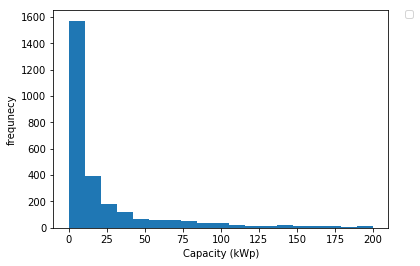

In [70]:
bins=np.linspace(0,200,20)
plt.hist(dach_df["Shape_Area"]/6, bins) # Assuming that on average 6 m^2 of area is required per kWp of PV installed
plt.ylabel("frequnecy")
plt.xlabel("Capacity (kWp)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Dach innerhalb parzelle

In [297]:
# Joined the dach shp file with the parzelle shp file in QGIS and created joint dach und parzelle.shp
fp = r"H:\Data\Hackaton SBB\SBB_MaximizePV\joint dach und parzelle.shp"
dach_und_parzelle_df = gpd.read_file(fp)
dach_und_parzelle_df.head()

,ID,OBJEKTNR,ORT,PARZNR,EIGENTUEME,NUTZUNG,NUTZUNG_TY,UPPERCASE,FLAECHE_BE,BUCHUNGSKR,...,minShape_A,maxShape_A,medianSh_1,sumID1,meanID1,minID1,maxID1,medianID1,count,geometry
0,76308,VD-00035-00000000598-19-0,00035,00000000598,1,19-0,9,VD-00035-00000000598-19-0,23378.5,5000,...,88.11504,100.44400,94.27952,13607.0,6803.0,6433.0,7174.0,6803.5,2.0,"POLYGON ((536352.8854194906 152901.6491801694,..."
1,74722,NE-01154-00000006714-23-0,01154,00000006714,2,23-0,3,NE-01154-00000006714-23-0,3063.6,4400,...,73.34018,590.56624,125.57506,11714.0,3904.0,3676.0,4287.0,3751.0,3.0,"POLYGON ((552902.1614612734 216014.1398160398,..."
2,76949,VD-00031-00000005986-28-b,00031,00000005986,2,28-b,8,VD-00031-00000005986-28-B,5321.6,4400,...,4553.35479,4553.35479,4553.35479,2694.0,2694.0,2694.0,2694.0,2694.0,1.0,"POLYGON ((538015.469858797 152080.1074685648, ..."
3,76948,VD-00031-00000005986-28-c,00031,00000005986,2,28-c,8,VD-00031-00000005986-28-c,937.5,4400,...,151.17640,4553.35479,2352.26560,7418.0,3709.0,2694.0,4724.0,3709.0,2.0,"POLYGON ((537989.7275093556 152069.9499407161,..."
4,76850,BE-01440-00000003607-23-b,01440,00000003607,2,23-b,3,BE-01440-00000003607-23-b,21812.2,4400,...,85.60548,1517.78168,418.31192,17632.0,3526.0,1902.0,4207.0,3740.0,5.0,"POLYGON ((597847.5955580231 199584.9701437011,..."


## Distribution of capacity, per Parzelle

No handles with labels found to put in legend.


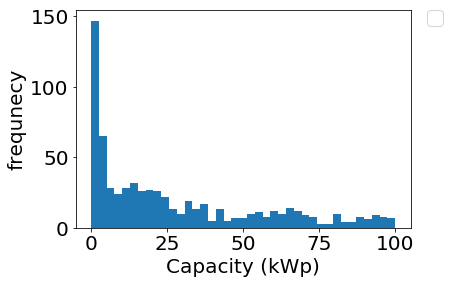

In [300]:
bins=np.linspace(0,100,40)
plt.hist(dach_und_parzelle_df["sumShape_A"]/6, bins)# Assuming that on average 6 m^2 of area is required per kWp of PV installed
plt.ylabel("frequnecy")
plt.xlabel("Capacity (kWp)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Ranking der gesamten Shape_Area nach Parzelle

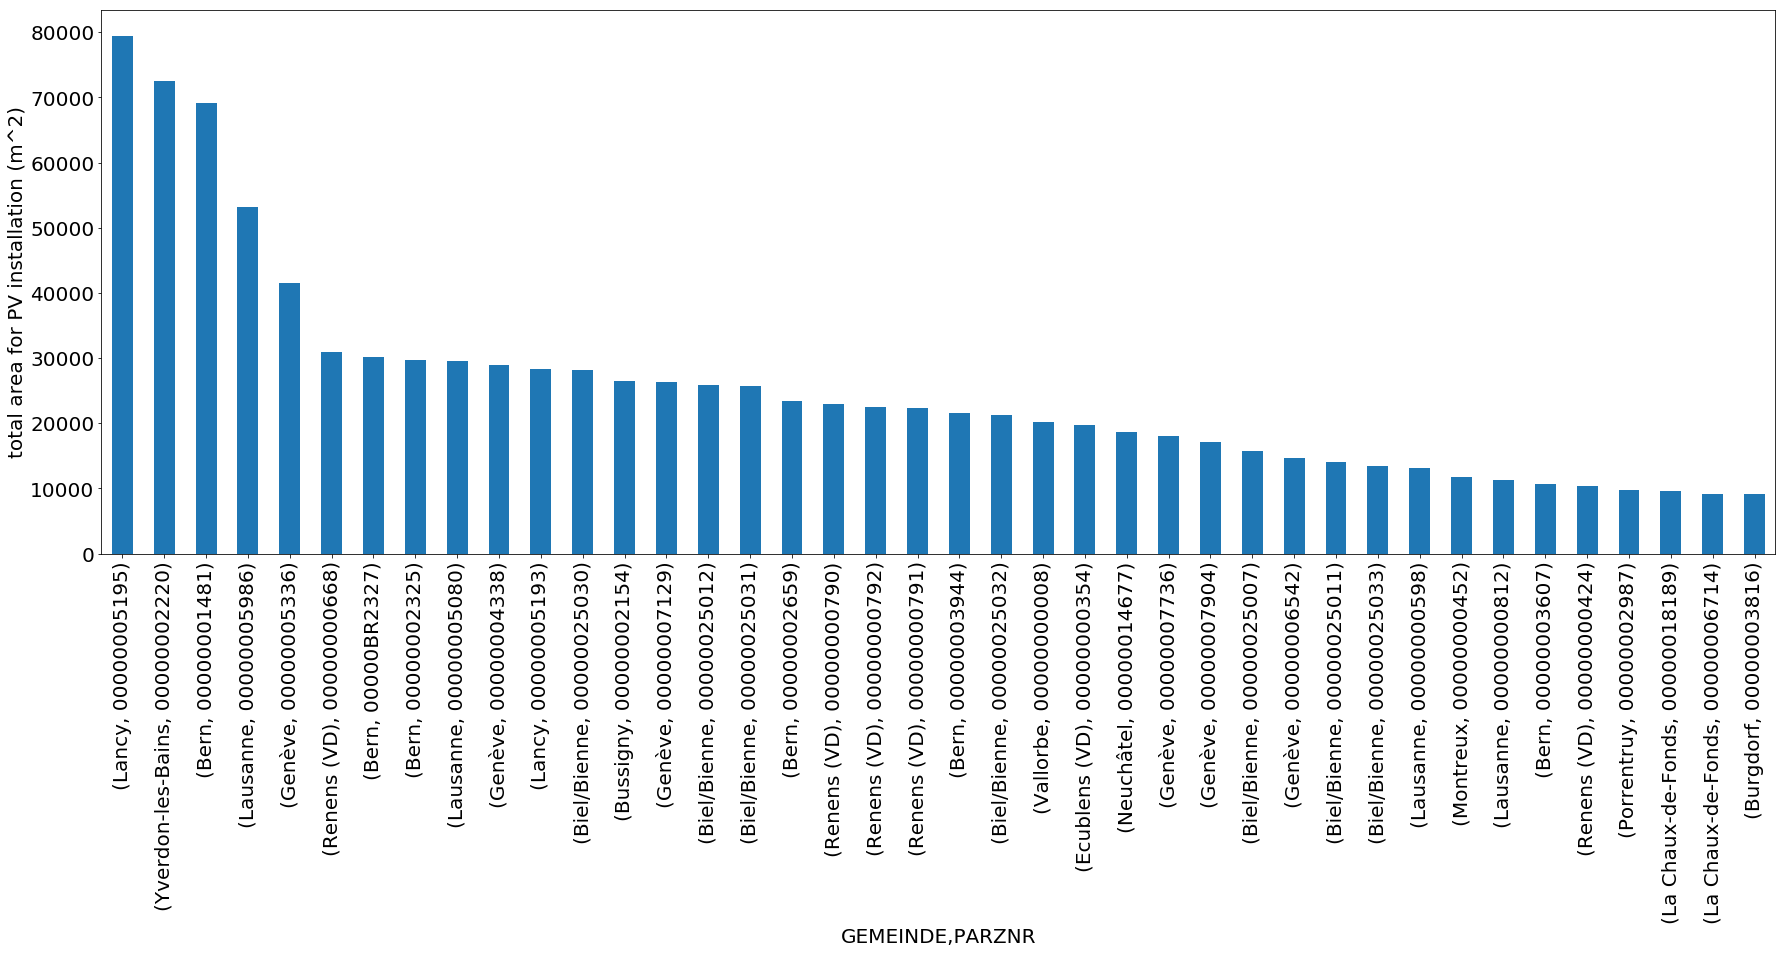

In [303]:
# in kWp Installed capacity, assuming 6 m2/kWp
fig, ax = plt.subplots(1, figsize=(30, 10))
dach_und_parzelle_df.groupby(["GEMEINDE",'PARZNR']).sum().sort_values(by="sumShape_A",ascending=False)[["sumShape_A"]][:40].plot.bar(ax=ax)
plt.ylabel("total area for PV installation (m^2)")
plt.rcParams.update({'font.size': 20})
ax.get_legend().remove()

# Levelized cost of electricity (LCOE)
In this section we calculate the levelized cost of electricity for PV. The capital costs of PV systems of various sizes were referenced from an update (which is not yet published) for a previous study <a href="https://www.psi.ch/lea/HomeEN/Final-Report-BFE-Project.pdf">Potentials, costs and environmental assessment of electricity generation technologies, 9 Solar Photovoltaics</a> done by <a href="https://www.psi.ch/ta/xzhang">Xiaojin Zhang</a>.

Text(0.5, 0, 'Size (kWp)')

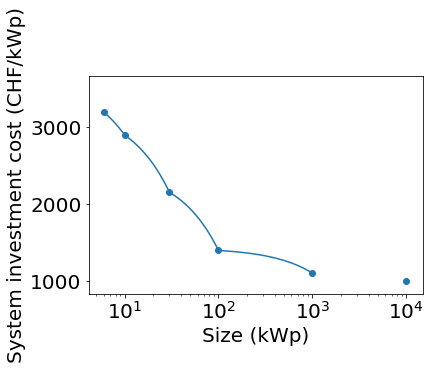

In [304]:
XS = [0,6,10,30,100,1000,10000]
YS = [3500,3192,2895,2154,1399,1106,1000]

fit_func = interpolate.interp1d(XS, YS)

def fit_capex_curve(size):
    return fit_func(size)
xs = np.linspace(6, 1000, 1000000)

plt.semilogx(xs, fit_capex_curve(xs), label="Marginal")
plt.scatter(XS, YS)
plt.ylabel("System investment cost (CHF/kWp)")
plt.xlabel("Size (kWp)")

In [305]:
def discounted(rate, lifetime):
    array = np.arange(lifetime)
    return (1 + rate) ** (-1 * (array+1))

def degraded(rate, lifetime):
    array = np.arange(lifetime)
    return (1 - rate) ** (array)

def LCOE(capex, annual_opex, decommissioning, annual_electricity, degradation, discount_rate, lifetime):
    opex_sum = (annual_opex * discounted(discount_rate, lifetime)).sum()
    discounted_electricity_sum = (annual_electricity * degraded(degradation, lifetime) * 
                                  discounted(discount_rate, lifetime)).sum()
 
    decommissiong_discounted = decommissioning * (1 + discount_rate) ** -lifetime
   
    return (capex + opex_sum + decommissiong_discounted) / discounted_electricity_sum

In [306]:
performance_ratio=.8 
module_efficiency=.17 #average module efficiency
unit_area=6 # average m2/kWp
inverter_efficiency=.98
degradation_rate=.005 #0.5% drop per year
discount_rate=.05 #interest rate for dicounting cashflows
lifetime=30 #years

In [307]:
def append_new_properties(obj):
    capacity = obj['sumShape_A'] / 6
    capital_cost = float(fit_capex_curve(capacity)) if capacity<=10000 else 800
    annual_opex = 20 if capacity > 30 else 30
    decommissioning = capital_cost * .27 / 2 if capacity >=30 else capital_cost / 8
    # note here we used the average yield for entire Switzerland, rather than yield for each inndividual installed area
    # this is a *HUGE* shortcoming due to time constraint in the Hackdays, we didn't have enough time to get data from eg. Sonnendach
    annual_electricity = 1013 #yield/kWp/year, avg. Switzerland
    levelized_cost=LCOE(capital_cost, 
                        annual_opex,  
                        decommissioning, 
                        annual_electricity,  
                        degradation_rate, #degradation rate
                        discount_rate, #discount rate
                        lifetime) #Lifetime
    
    obj.update({
        'capacity': capacity,
        'capital_cost': capital_cost,
        'annual_opex': annual_opex,
        'decommissioning': decommissioning,
        'generation': annual_electricity,
        'levelized_cost': levelized_cost
    })
    return obj

In [308]:
dach_und_parzelle_lcoe_df=[]
for x in dach_und_parzelle_df.to_dict('records'):
    dach_und_parzelle_lcoe_df.append(append_new_properties(x))

In [309]:
dach_und_parzelle_lcoe_df=pd.DataFrame(dach_und_parzelle_lcoe_df)

# Ranking of Gemeinde, Parzelle in terms of production potential

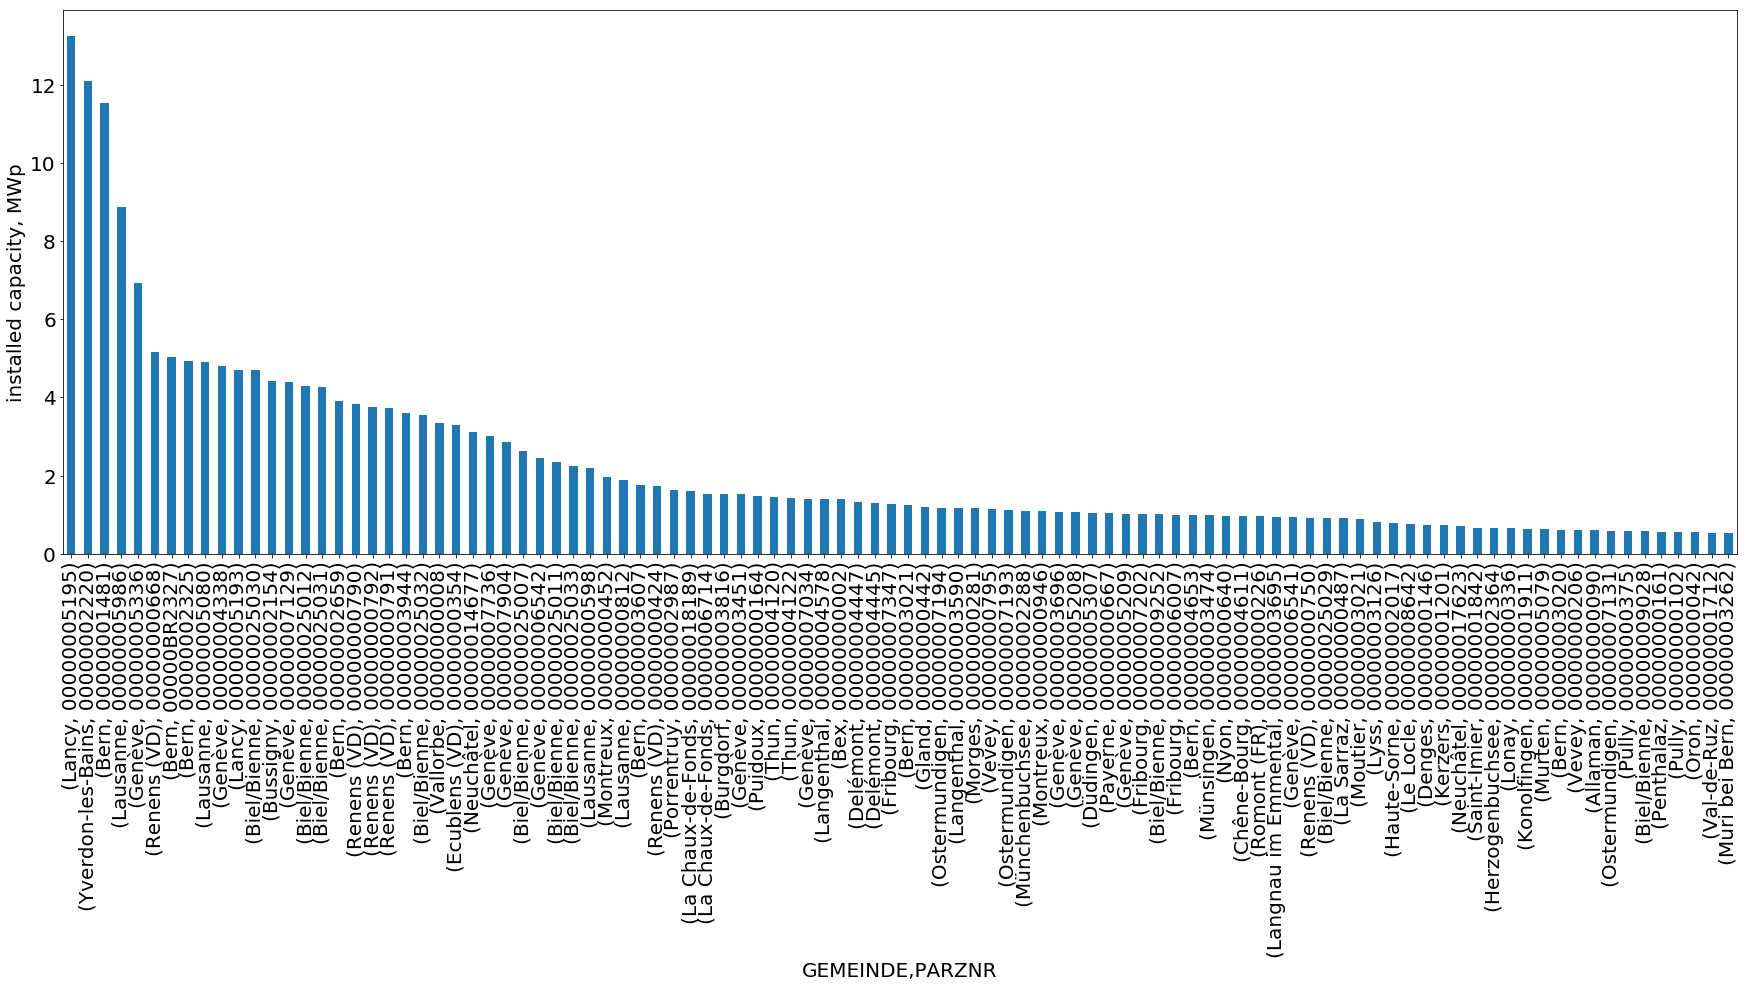

In [310]:
fig, ax = plt.subplots(1, figsize=(30, 10))
dach_und_parzelle_lcoe_df.groupby(["GEMEINDE",'PARZNR']).sum().sort_values(by="capacity",ascending=False)[["capacity"]][:100].div(1000).plot.bar(ax=ax)
plt.ylabel("installed capacity, MWp")
plt.rcParams.update({'font.size': 20})
ax.get_legend().remove()

# Ranking of Gemeinde, Parzelle in terms of levelized cost of electricity, in CHF/kWh

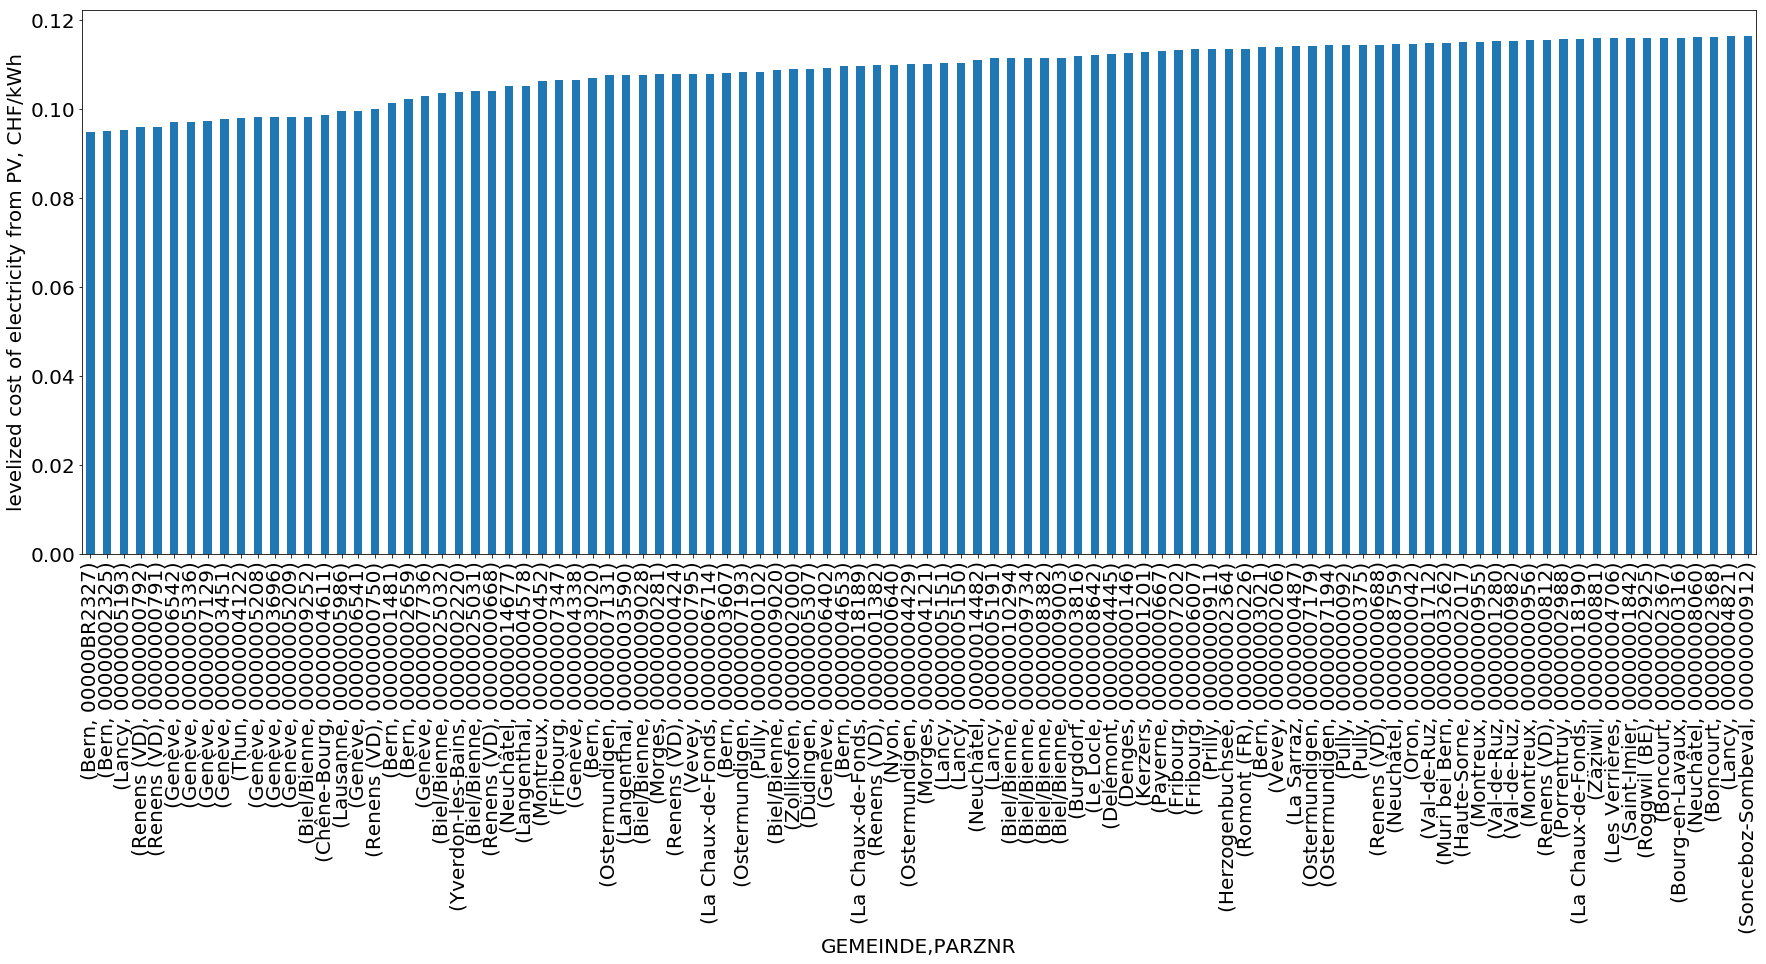

In [316]:
fig, ax = plt.subplots(1, figsize=(30, 10))
dach_und_parzelle_lcoe_df.groupby(["GEMEINDE",'PARZNR']).mean().sort_values(by="levelized_cost")[["levelized_cost"]][:100].plot.bar(ax=ax)
plt.ylabel("levelized cost of electricity from PV, CHF/kWh")
plt.rcParams.update({'font.size': 20})
ax.get_legend().remove()

Text(0, 0.5, 'potential generation, GWh/year')

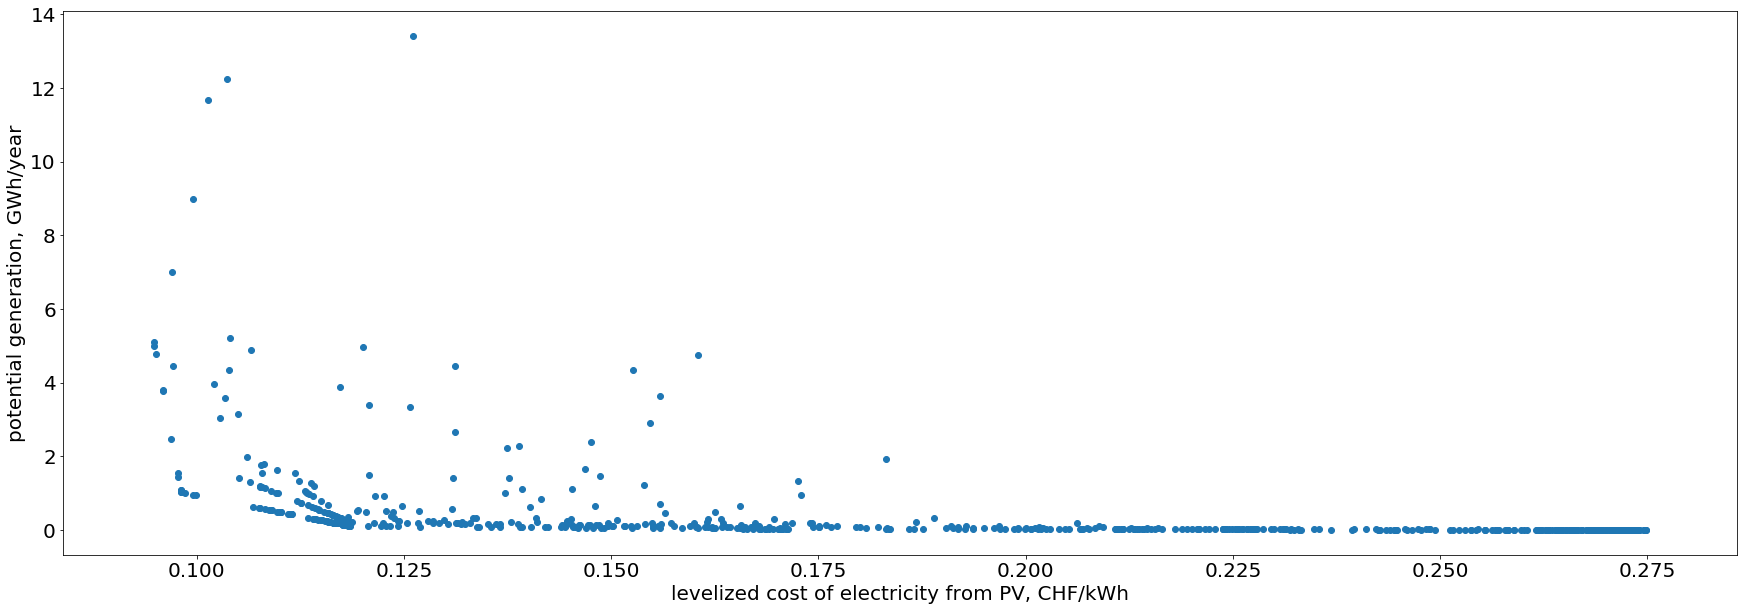

In [369]:
x=dach_und_parzelle_lcoe_df.groupby(["GEMEINDE",'PARZNR']).mean()["levelized_cost"]
y=dach_und_parzelle_lcoe_df.groupby(["GEMEINDE",'PARZNR']).sum()["capacity"]*1013/1000000
fig, ax = plt.subplots(1, figsize=(30, 10))
plt.scatter(x, y)
plt.xlabel("levelized cost of electricity from PV, CHF/kWh")
plt.ylabel("potential generation, GWh/year")

Text(0, 0.5, 'potential generation, per Parzelle, GWh/year')

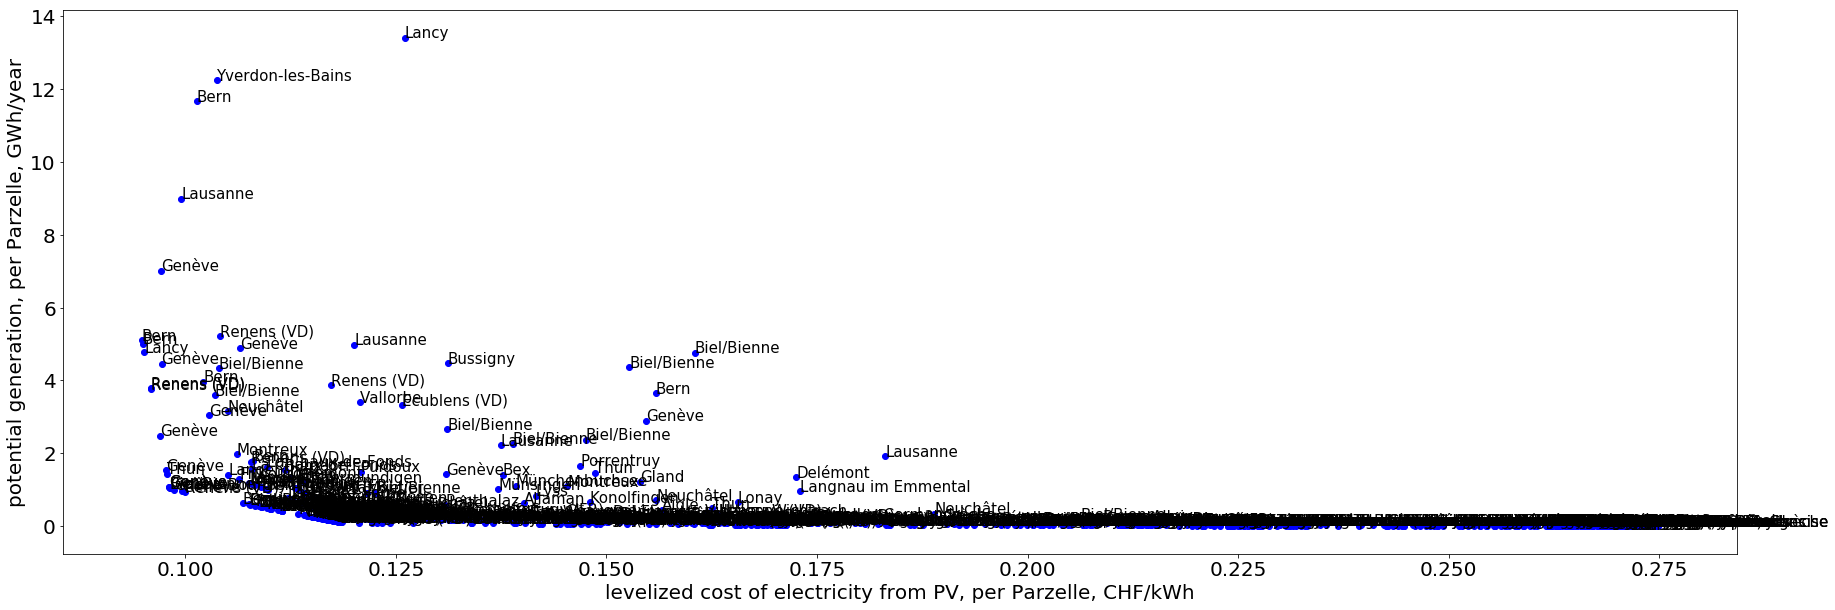

In [391]:
fig, ax = plt.subplots(1, figsize=(30, 10))
x_coords=dach_und_parzelle_lcoe_df.groupby(["GEMEINDE",'PARZNR']).mean()["levelized_cost"]
y_coords=dach_und_parzelle_lcoe_df.groupby(["GEMEINDE",'PARZNR']).sum()["capacity"]*1013/1000000

gemeindes=dach_und_parzelle_lcoe_df.groupby(["GEMEINDE",'PARZNR']).mean()[["levelized_cost"]].reset_index()["GEMEINDE"].tolist()

for i,gemeinde in enumerate(gemeindes):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, color="blue")
    plt.text(x, y, gemeinde, fontsize=15)
    
plt.xlabel("levelized cost of electricity from PV, per Parzelle, CHF/kWh")
plt.ylabel("potential generation, per Parzelle, GWh/year")

# Total generation potential (GWh/year) from SBB roofs, with LCOE<10 or 15 Rp/kWh

In [403]:
dach_und_parzelle_lcoe_df.loc[dach_und_parzelle_lcoe_df["levelized_cost"]<0.1].sum()["capacity"].sum()*1013/1000000

153.1684567292217

In [404]:
dach_und_parzelle_lcoe_df.loc[dach_und_parzelle_lcoe_df["levelized_cost"]<0.15].sum()["capacity"].sum()*1013/1000000

269.9174227733367

# Corresponding greenhouse gas emission reductions (tons of CO2 equivalens/year)

average life cycle greenhouse gas emissions from Swiss grid supply (consumption-based): 102 g CO2/kWh

average life cycle greenhouse gas emissions from PV supply in Switzerland: 56 g CO2/kWh

In [409]:
153*(102-56)*1000000/1000/1000

7038.0

In [410]:
#tons of CO2 equivalens
270*(102-56)*1000000/1000/1000

12420.0